# Read dataset and create data loaders

In [35]:
# Import torch and CIFAR dataset
import torch
import torchvision
import torchvision.transforms as transforms

In [36]:
# Initialise vectors and batch size
transform= transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
batch_size=4
# Load training and testing dataset
trainset= torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform= transform)
trainloader= torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset= torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader= torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
# Define labels
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'lorry')

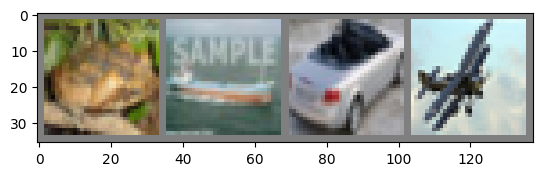

frog  ship  car   plane


In [37]:
# From the PyTorch's tutorial on image classification
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    '''
    Show an image
    Input: image file to show
    Output: image
    '''
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

#Create model

## Stem
*   Takes images as inputs
*   Extracts a feature representation from them

In [38]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1= nn.Conv2d(3,6,5)
    self.pool= nn.MaxPool2d(2,2)
    self.conv2= nn.Conv2d(6,16,5)
    self.fc1= nn.Linear(16 * 5 * 5, 120)
    self.fc2=nn.Linear(120,84)
    self.fc3=nn.Linear(84,10)

  def forward(self,x):
    x= self.pool(F.relu(self.conv1(x)))
    x= self.pool(F.relu(self.conv2(x)))
    x= torch.flatten(x,1)
    x= F.relu(self.fc1(x))
    x= F.relu(self.fc2(x))
    x= self.fc3(x)
    return x

In [39]:
import torch.nn as nn
import torch.nn.functional as F
class Stem(nn.Module):
  '''
  Extract features using a simple convolutional layer
  '''
  def __init__(self) -> None:
     super(Stem,self).__init__()
     self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)


  def forward(self,x):
    x = self.conv1(x)
    # print("Stem output shape in forward pass:", x.shape)
    return x

## Block

In [40]:
class ExpertBranch(nn.Module):
  '''
  Expert branch predicting vector a with K elements from input tensor X
  '''
  def __init__(self, input_channels, k=4, r=4):
    super(ExpertBranch,self).__init__()
    # Spatially pool x
    self.pool= nn.AdaptiveAvgPool2d(1)
    #Forward through fc1, reducing by r
    self.fc1= nn.Linear(input_channels, input_channels//r)
    # Activation function ReLu
    self.relu= nn.ReLU()
    # Forward through fc2
    self.fc2= nn.Linear(input_channels//r,k)

  def forward(self,x):
    # Spatially pool X
    x = self.pool(x)
    # Forward through fc1, reducing by r
    x= x.squeeze(-1).squeeze(-1)
    x = self.fc1(x)
    # Processed through non-linear activation g
    x = F.relu(x)
    # Pass through fc2
    x = self.fc2(x)
    # Forward with softmax
    x = F.softmax(x,dim=1)
    return x

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class Block(nn.Module):
  '''
  Block
  '''
  def __init__(self, input_channels, output_channels, k=4, r=4, kernel_size=3, stride=1, padding=1):
    super(Block, self).__init__()
    self.k= k
    self.expertBranch = ExpertBranch(input_channels, k=k, r=r)
    # Input from first block
    # Input from previous block for rest
    # Generate vector a with K elements from X as a= E(X)
    # Create K convolutional layers
    self.convs= nn.ModuleList([
        nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size, stride= stride, padding=padding)
        for _ in range(k)
    ])

  def forward(self,x):
    a = self.expertBranch(x)
    conv_outputs = [conv(x) for conv in self.convs]
    stacked = torch.stack(conv_outputs, dim=1)
    a= a.view(a.size(0), self.k, 1,1,1)

    out = (a* stacked).sum(dim=1)

    return out

## Backbone

In [42]:
class Backbone(nn.Module):
  '''
  N blocks
  '''
  def __init__(self, input_channels=64, hidden_channels=64, num_blocks=3, k=4, r=4):
    super(Backbone, self).__init__()
    self.blocks= nn.ModuleList()

    # First block takes input from stem
    self.blocks.append(Block(input_channels, hidden_channels, k=k, r=r))

    # Rest of blocks take input form previous block
    for _ in range(1, num_blocks):
      self.blocks.append(Block(hidden_channels, hidden_channels, k=k, r=r))

  def forward(self, x):
    for idx, block in enumerate(self.blocks):
      # print(f"Backbone Block {idx+1} output shape:", x.shape)
      x = block(x)
      # print(f"Backbone Block {idx+1} output shape:", x.shape)
    return x

## Classifier

In [48]:
class Classifier(nn.Module):
  def __init__(self, input_channels, num_classes=10, use_mlp=False):
    super(Classifier,self).__init__()
    # Spatially pool
    self.pool = nn.AdaptiveAvgPool2d(1)
    self.use_mlp= use_mlp

    if use_mlp:
      self.classifier= nn.Sequential(
          nn.Linear(input_channels, input_channels//2),
          nn.ReLU(),
          nn.Dropout(0.5), # Deeper network with 3 layers
          nn.ReLU(),
          nn.Linear(input_channels //2, num_classes)
      )
    else:
      self.classifier= nn.Linear(input_channels, num_classes)

  def forward(self, x):
    x = self.pool(x).squeeze(-1).squeeze(-1)
    # print("Classifier input shape:", x.shape)
    out = self.classifier(x)
    # print("Classifier output shape (logits):", out.shape)
    return out


# Model

In [44]:
class Model(nn.Module):
  def __init__(self, stem_channels= 64, hidden_channels=64, num_blocks=3, k=4, r=4, num_classes=10, use_mlp=False):
    super(Model, self).__init__()
    # Call stem
    self.stem= Stem()
    # Call backbone
    self.backbone= Backbone(input_channels=stem_channels, hidden_channels= hidden_channels, num_blocks=num_blocks, k=k, r=r)
    # Call classifier
    self.classifier= Classifier(input_channels=hidden_channels, num_classes=num_classes, use_mlp= use_mlp)

  def forward(self,x):
    x= self.stem(x)
    x= self.backbone(x)
    x= self.classifier(x)
    return x

# Create the loss and optmiser


In [45]:
import torch.optim as optim

model = Model(
    stem_channels=64,
    hidden_channels=64,
    num_blocks=3,
    k=4,
    r=4,
    num_classes=10,
    use_mlp=True
)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training


Epoch 1/10


Train Loss: 2.1025 | Accuracy: 21.03%
Val   Loss: 1.9876 | Accuracy: 26.04%
Saved best model.

Epoch 2/10


Train Loss: 2.0225 | Accuracy: 25.81%
Val   Loss: 1.9586 | Accuracy: 27.64%
Saved best model.

Epoch 3/10


Train Loss: 1.9863 | Accuracy: 27.62%
Val   Loss: 1.9027 | Accuracy: 31.18%
Saved best model.

Epoch 4/10


Train Loss: 1.9582 | Accuracy: 28.86%
Val   Loss: 1.8565 | Accuracy: 33.96%
Saved best model.

Epoch 5/10


Train Loss: 1.9430 | Accuracy: 29.93%
Val   Loss: 1.8639 | Accuracy: 32.03%

Epoch 6/10


Train Loss: 1.9257 | Accuracy: 30.58%
Val   Loss: 1.8220 | Accuracy: 35.47%
Saved best model.

Epoch 7/10


Train Loss: 1.9213 | Accuracy: 30.76%
Val   Loss: 1.8523 | Accuracy: 32.97%

Epoch 8/10


Train Loss: 1.9092 | Accuracy: 31.08%
Val   Loss: 1.8373 | Accuracy: 35.59%
Saved best model.

Epoch 9/10


Train Loss: 1.9070 | Accuracy: 31.27%
Val   Loss: 1.7879 | Accuracy: 35.32%

Epoch 10/10


Train Loss: 1.9029 | Accuracy: 31.49%
Val   Loss: 1.8221 | Accuracy: 34.90%

Training Complete

📊 Final Averages Over All Epochs
Average Train Loss: 1.9579
Average Train Accuracy: 28.84%
Average Val   Loss: 1.8691
Average Val   Accuracy: 32.51%
Plots saved: loss_curve.png and accuracy_curve.png


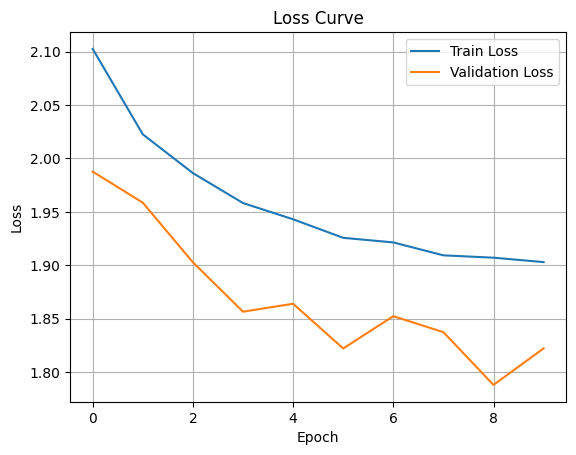

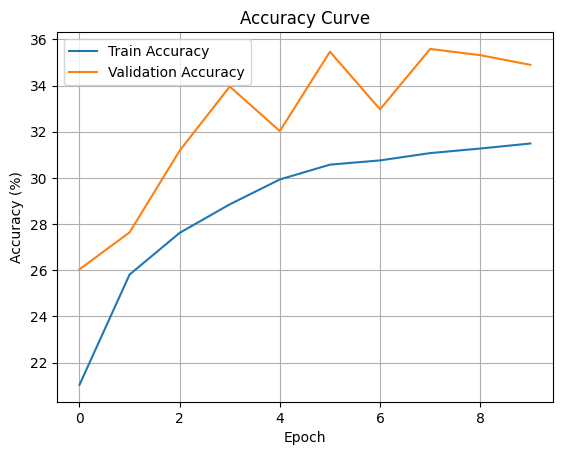

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

# ---------- 1. Set up device ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- 2. Load CIFAR-10 ----------
# Initialise vectors and batch size
transform= transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
batch_size=4
# Load training and testing dataset
trainset= torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform= transform)
trainloader= torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset= torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader= torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
# Define labels
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'lorry')

# ---------- 3. Initialise Model ----------
model = Model(
    stem_channels=64,
    hidden_channels=64,
    num_blocks=3,
    k=4,
    r=4,
    num_classes=10,
    use_mlp=True
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ---------- Log training ----------
train_losses, val_losses = [], []
train_accuracies = []
val_accuracies = []

# ---------- Training + Validation Loops ----------
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(loader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / len(loader), 100 * correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    total = 0
    correct = 0
    loss = 0.0

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Validating", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return loss / len(loader), 100 * correct / total

# ---------- 5. Main Loop ----------
epochs = 10
best_acc = 0.0

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    train_loss, train_acc = train(model, trainloader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, testloader, criterion, device)


    # Log metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Accuracy: {train_acc:.2f}%")
    print(f"Val   Loss: {val_loss:.4f} | Accuracy: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print("Saved best model.")

print("\nTraining Complete")

# ---------- 8. Print Final Averages ----------
avg_train_loss = sum(train_losses) / len(train_losses)
avg_val_loss = sum(val_losses) / len(val_losses)
avg_train_acc = sum(train_accuracies) / len(train_accuracies)
avg_val_acc = sum(val_accuracies) / len(val_accuracies)

print("\n📊 Final Averages Over All Epochs")
print(f"Average Train Loss: {avg_train_loss:.4f}")
print(f"Average Train Accuracy: {avg_train_acc:.2f}%")
print(f"Average Val   Loss: {avg_val_loss:.4f}")
print(f"Average Val   Accuracy: {avg_val_acc:.2f}%")


# ---------- 7. Plot Results ----------

# Plot Loss
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.savefig("loss_curve.png")

# Plot Accuracy
plt.figure()
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()
plt.savefig("accuracy_curve.png")

print("Plots saved: loss_curve.png and accuracy_curve.png")


Averages:


*   Train Loss: 1.7223, Accuracy: 38.21%, Validation Loss: 1.7194, Accuracy: 38.25%
*   Train Loss: 1.7106, Accuracy: 34.80%, Validation Loss: 1.7984, Accuracy: 35.98%

*   Train Loss: 1.8150, Accuracy: 34.54%, Val   Loss: 1.7848 Accuracy: 36.13%

*   Train Loss: 1.9579, Accuracy: 28.84%, Val   Loss: 1.8691, Accuracy: 32.51%





# Test training data

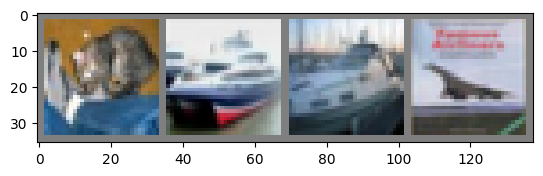

GroundTruth:  cat   ship  ship  plane


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [47]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
outputs= model(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))